##### Import required libraries

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import cv2
import matplotlib.pylab as plt

##### Display samples

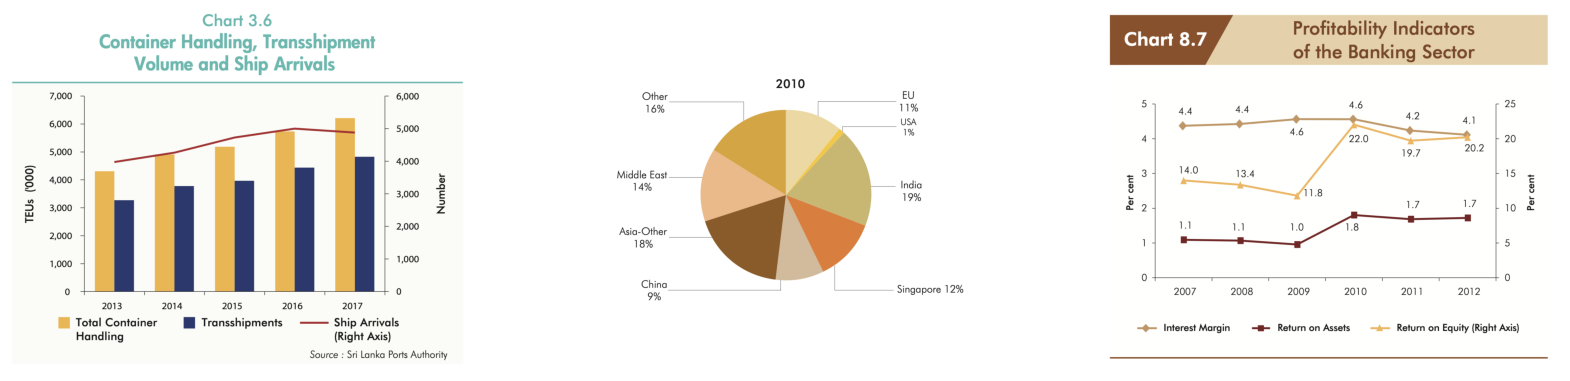

In [2]:
charts = glob('CBSLDataset/charts/*.png')
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
bar_chart = cv2.cvtColor(cv2.imread(charts[609]), cv2.COLOR_BGR2RGB)
pie_chart = cv2.cvtColor(cv2.imread(charts[868]), cv2.COLOR_BGR2RGB)
line_chart = cv2.cvtColor(cv2.imread(charts[45]), cv2.COLOR_BGR2RGB)
ax[0].imshow(bar_chart)
ax[1].imshow(pie_chart)
ax[2].imshow(line_chart)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

##### Read and preprocess images

In [3]:
dim = (128, 128)
chart_types = list(map(lambda x: x.strip('data/charts')[:-9], charts))
img_cv2 = list(map(lambda path: cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), dim), charts))
data_dic = {'file_path': charts, 'img_cv2': img_cv2, 'chart_type': chart_types}
data = pd.DataFrame(data_dic)

In [4]:
img_cv2 = np.stack(img_cv2)

In [5]:
data

,file_path,img_cv2,chart_type
0,data/charts/line_0050.png,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",line
1,data/charts/line_0044.png,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",line
2,data/charts/bar_0133.png,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",bar
3,data/charts/bar_0127.png,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",bar
4,data/charts/line_0078.png,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",line
...,...,...,...
1060,data/charts/pie_0097.png,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",pie
1061,data/charts/line_0075.png,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",line
1062,data/charts/bar_0102.png,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",bar
1063,data/charts/bar_0116.png,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",bar


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
chart_types_tr = le.fit_transform(chart_types)
X_train, X_test, y_train, y_test = train_test_split(img_cv2, chart_types_tr)
X_train = X_train/255
X_test = X_test/255

In [7]:
le.classes_

array(['bar', 'line', 'pie'], dtype='<U4')

##### Build, compile and train a shallow NN

##### Build, compile and train a CNN

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras import Model
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import EarlyStopping

kernel_size = (3, 3)
pool_size = (2, 2)

input_ = Input(shape=X_train.shape[1:])
conv2d_1 = Conv2D(filters=64, kernel_size=kernel_size, activation='relu')(input_)
pooling_1 = MaxPooling2D(pool_size=pool_size)(conv2d_1)
conv2d_2 = Conv2D(filters=128, kernel_size=kernel_size, activation='relu')(pooling_1)
pooling_2 = MaxPooling2D(pool_size=pool_size)(conv2d_2)
flatten = Flatten()(pooling_2)
dense = Dense(100, activation='relu')(flatten)
output = Dense(3, activation='softmax')(dense)
cnn_model = Model(inputs=[input_], outputs=[output])
cnn_model.summary()

early_stopping = EarlyStopping(monitor='loss', patience=3)
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = cnn_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 115200)            0     

Epoch 1/30
25/25 [==============================] - 14s 552ms/step - loss: 1.0846 - accuracy: 0.4236 - val_loss: 1.0149 - val_accuracy: 0.4719
Epoch 2/30
25/25 [==============================] - 13s 542ms/step - loss: 1.0173 - accuracy: 0.4950 - val_loss: 1.0018 - val_accuracy: 0.4719
Epoch 3/30
25/25 [==============================] - 14s 543ms/step - loss: 1.0033 - accuracy: 0.4950 - val_loss: 0.9901 - val_accuracy: 0.4719
Epoch 4/30
25/25 [==============================] - 14s 544ms/step - loss: 0.9704 - accuracy: 0.5013 - val_loss: 0.9418 - val_accuracy: 0.6292
Epoch 5/30
25/25 [==============================] - 14s 548ms/step - loss: 0.9244 - accuracy: 0.5288 - val_loss: 0.9633 - val_accuracy: 0.4719
Epoch 6/30
25/25 [==============================] - 14s 549ms/step - loss: 0.8507 - accuracy: 0.5802 - val_loss: 0.7664 - val_accuracy: 0.5993
Epoch 7/30
25/25 [==============================] - 16s 626ms/step - loss: 0.8198 - accuracy: 0.6391 - val_loss: 1.0164 - val_accuracy: 0.6180

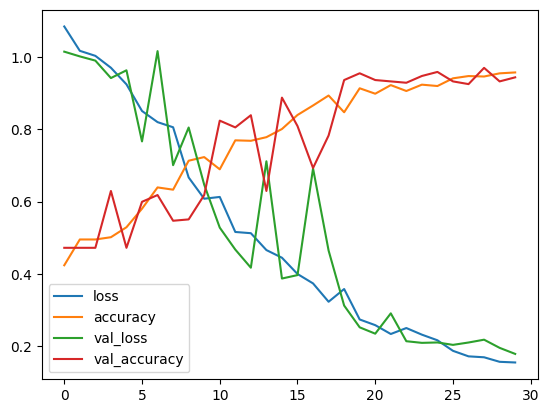

In [19]:
pd.DataFrame(history.history).plot()
plt.show()

In [10]:
cnn_model.evaluate(X_test, y_test)

9/9 [==============================] - 1s 85ms/step - loss: 0.1782 - accuracy: 0.9438


[0.1782023310661316, 0.9438202381134033]

9/9 [==============================] - 1s 85ms/step


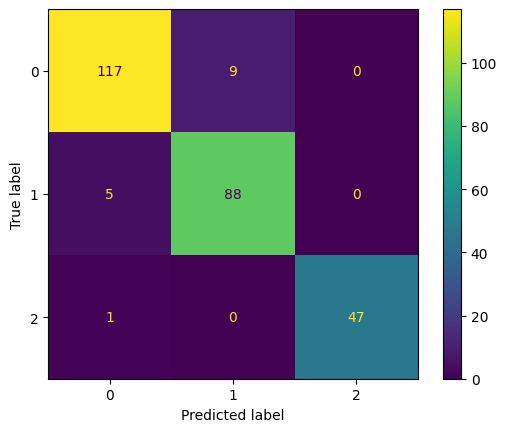

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_probabilities = cnn_model.predict(X_test)
predictions = np.argmax(predicted_probabilities, axis=1)
conf_mat = confusion_matrix(y_test, predictions)
conf_mat_display = ConfusionMatrixDisplay(conf_mat)
conf_mat_display.plot()
plt.show()

##### Missed Classifications

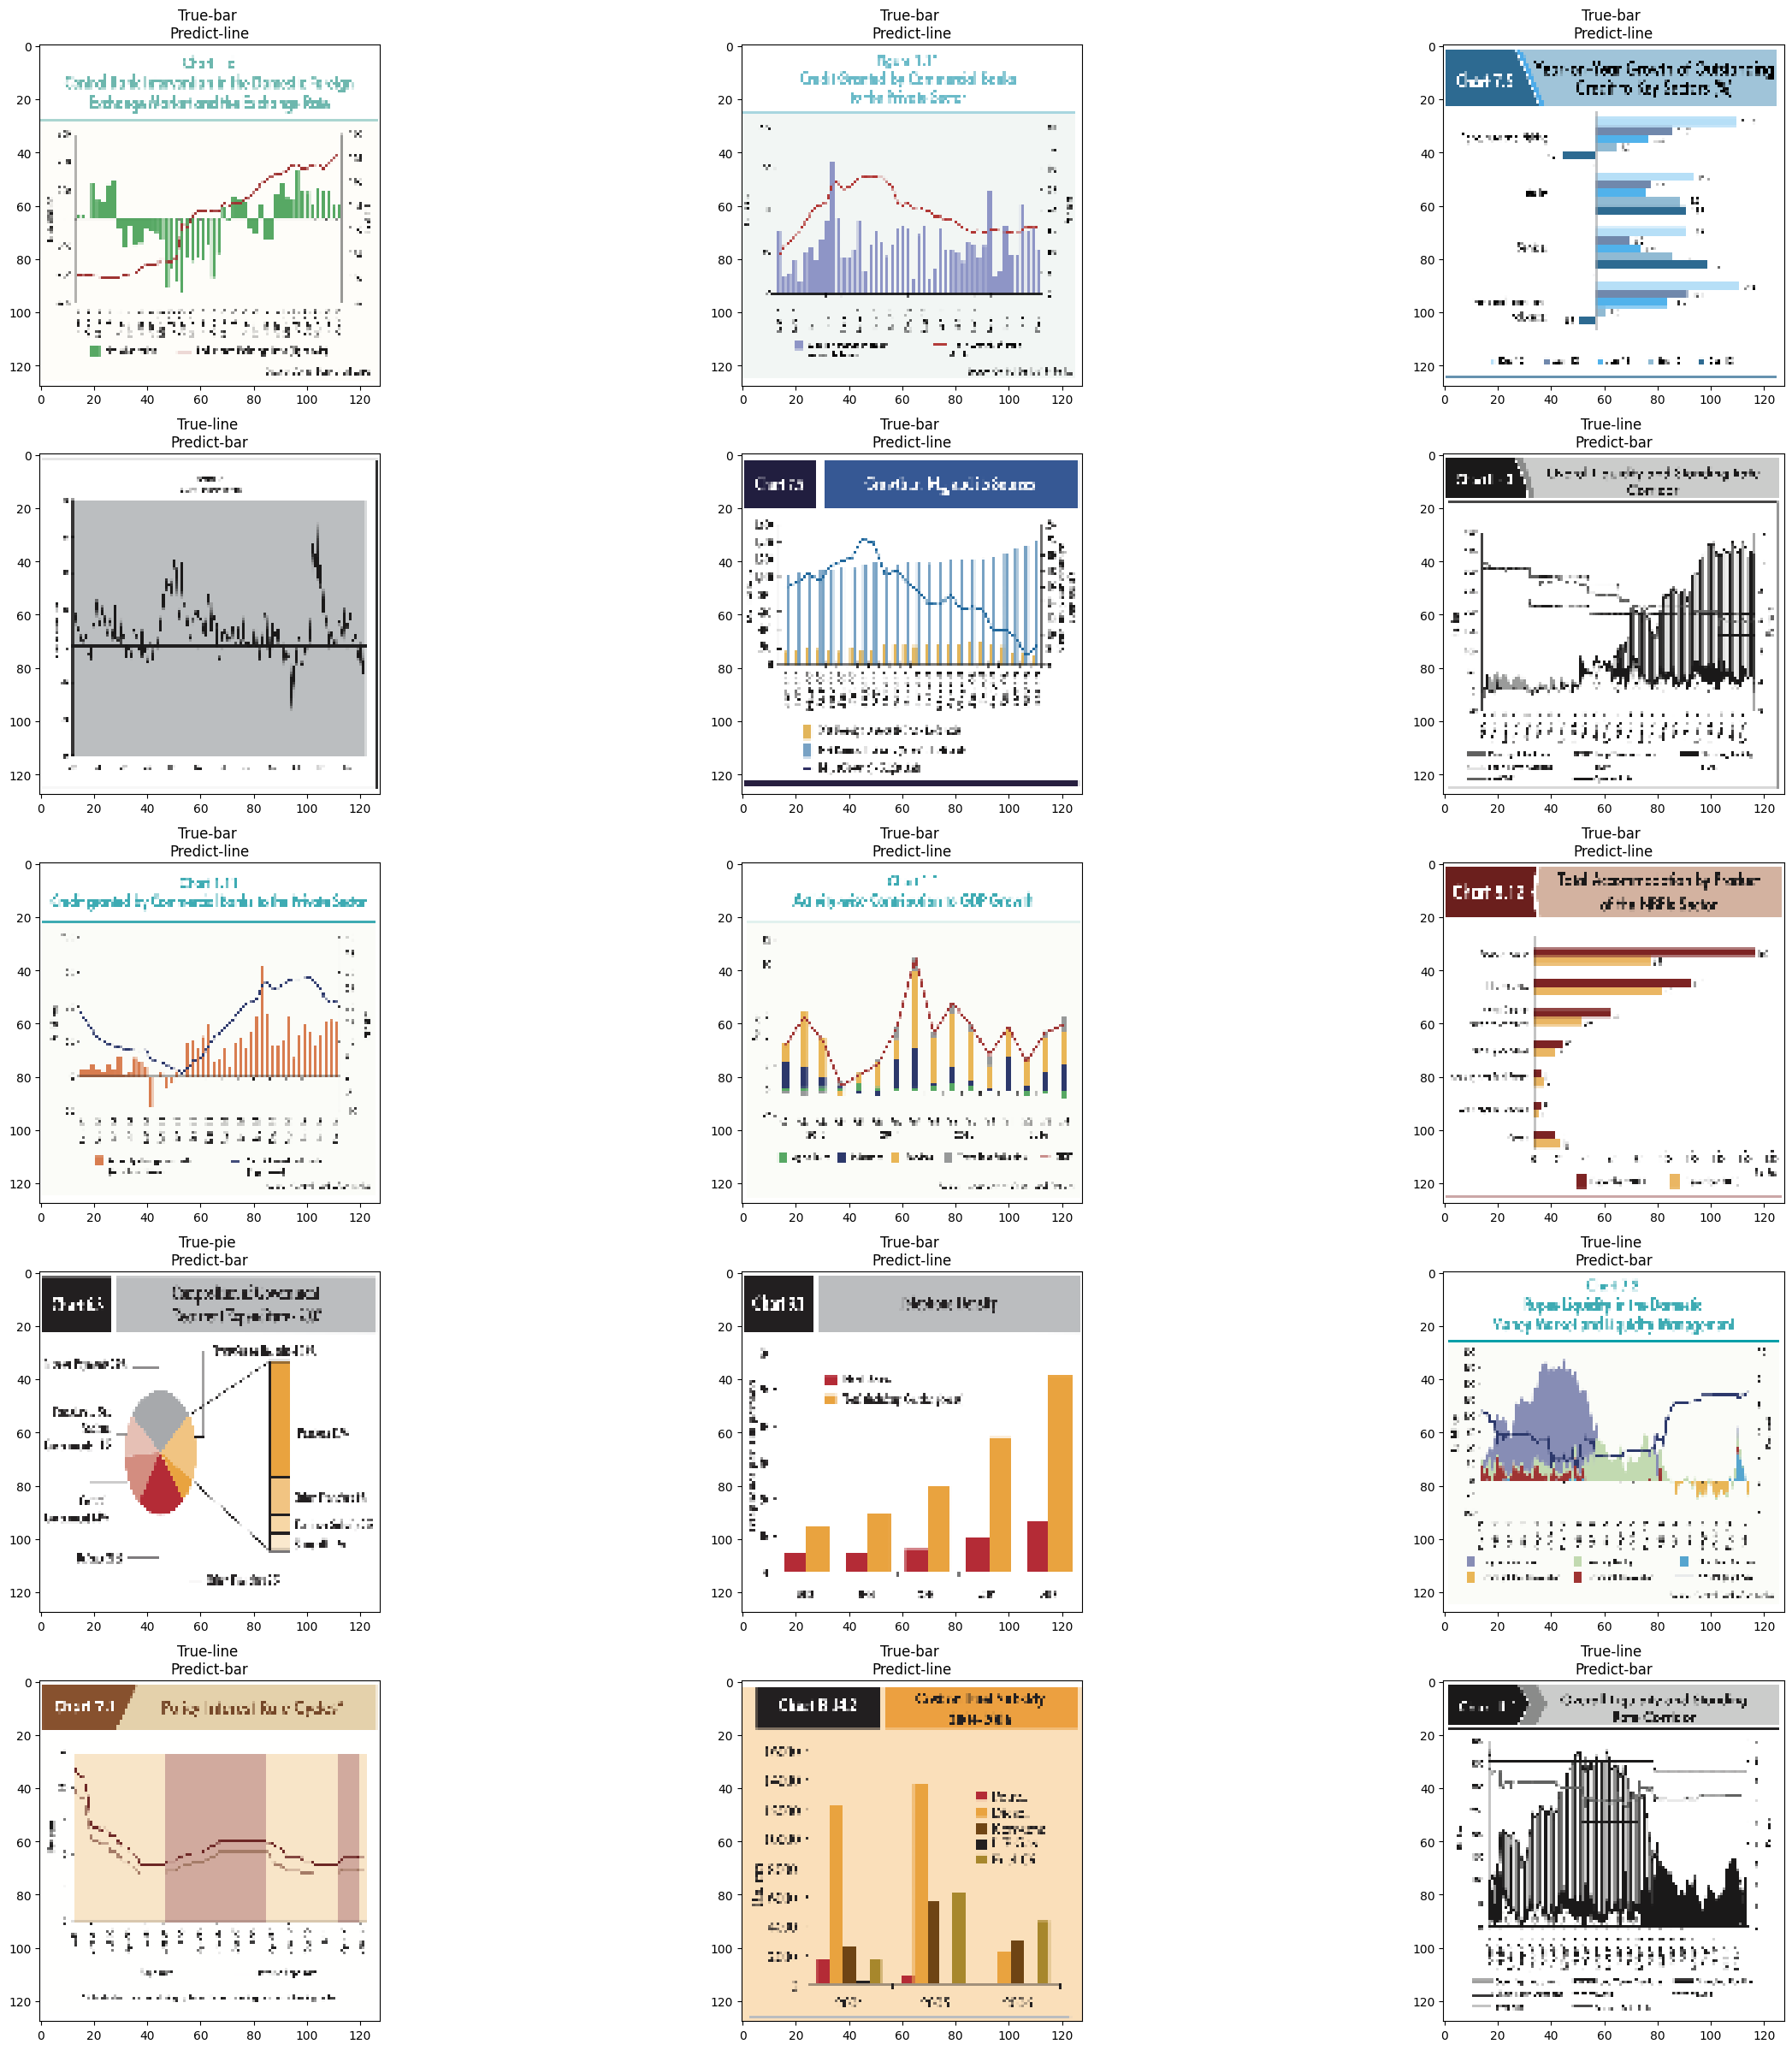

In [12]:
miss_pred = np.where(y_test != predictions)[0]
n_rows = np.ceil(len(miss_pred) / 3).astype(np.uint8)
n_cols = 3
fig, axes = plt.subplots(n_rows, 3, figsize=(30, 30))
axes = axes.ravel()

for i in range(n_rows * n_cols):
    try:
        axes[i].imshow(X_test[miss_pred[i]])
        axes[i].set_title('True-%s \nPredict-%s' % (le.classes_[y_test[miss_pred[i]]], le.classes_[predictions[miss_pred[i]]]))
    except IndexError:
        axes[i].axis('off')

##### Save the model

In [33]:
cnn_model.save('saved models/cnn_classifier.keras')

##### Inference

In [23]:
import cv2
import numpy as np
from keras.models import load_model

def model_predict(path, saved_model):
    dim = saved_model.input_shape[1:-1]
    img = cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB), dim) / 255
    img_exp = np.expand_dims(img, axis=0)
    prediction = np.argmax(saved_model(img_exp).numpy())
    return prediction

saved_model = load_model('saved models/cnn_classifier.keras')
model_predict(path='eval/chart.png', saved_model=saved_model)

1